In [1]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer,  MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler,  OrdinalEncoder
from sklearn.model_selection import train_test_split

import mlflow

In [2]:
import dagshub
dagshub.init(repo_owner='manikantmnnit', repo_name='remote-work-health-classificatio', mlflow=True)


Accessing as manikantmnnit

Initialized MLflow to track repo "manikantmnnit/remote-work-health-classificatio"

Repository manikantmnnit/remote-work-health-classificatio initialized!

In [3]:
# set the sklearn output format
from sklearn import set_config
set_config(transform_output="pandas")

In [4]:
import pathlib
from pathlib import Path

processed_data_path=Path.cwd().parent/'data'/'raw'/'post_pandemic_remote_work_health_impact_2025.csv'
df=pd.read_csv(processed_data_path)
df.head()

,Survey_Date,Age,Gender,Region,Industry,Job_Role,Work_Arrangement,Hours_Per_Week,Mental_Health_Status,Burnout_Level,Work_Life_Balance_Score,Physical_Health_Issues,Social_Isolation_Score,Salary_Range
0,2025-06-01,27,Female,Asia,Professional Services,Data Analyst,Onsite,64,Stress Disorder,High,3,Shoulder Pain; Neck Pain,2,$40K-60K
1,2025-06-01,37,Female,Asia,Professional Services,Data Analyst,Onsite,37,Stress Disorder,High,4,Back Pain,2,$80K-100K
2,2025-06-01,32,Female,Africa,Education,Business Analyst,Onsite,36,ADHD,High,3,Shoulder Pain; Eye Strain,2,$80K-100K
3,2025-06-01,40,Female,Europe,Education,Data Analyst,Onsite,63,ADHD,Medium,1,Shoulder Pain; Eye Strain,2,$60K-80K
4,2025-06-01,30,Male,South America,Manufacturing,DevOps Engineer,Hybrid,65,NaN,Medium,5,NaN,4,$60K-80K


In [5]:
print(df.columns)

df.duplicated().sum()
df.isnull().sum().sum()

Index(['Survey_Date', 'Age', 'Gender', 'Region', 'Industry', 'Job_Role',
       'Work_Arrangement', 'Hours_Per_Week', 'Mental_Health_Status',
       'Burnout_Level', 'Work_Life_Balance_Score', 'Physical_Health_Issues',
       'Social_Isolation_Score', 'Salary_Range'],
      dtype='object')


np.int64(1079)

<Axes: >

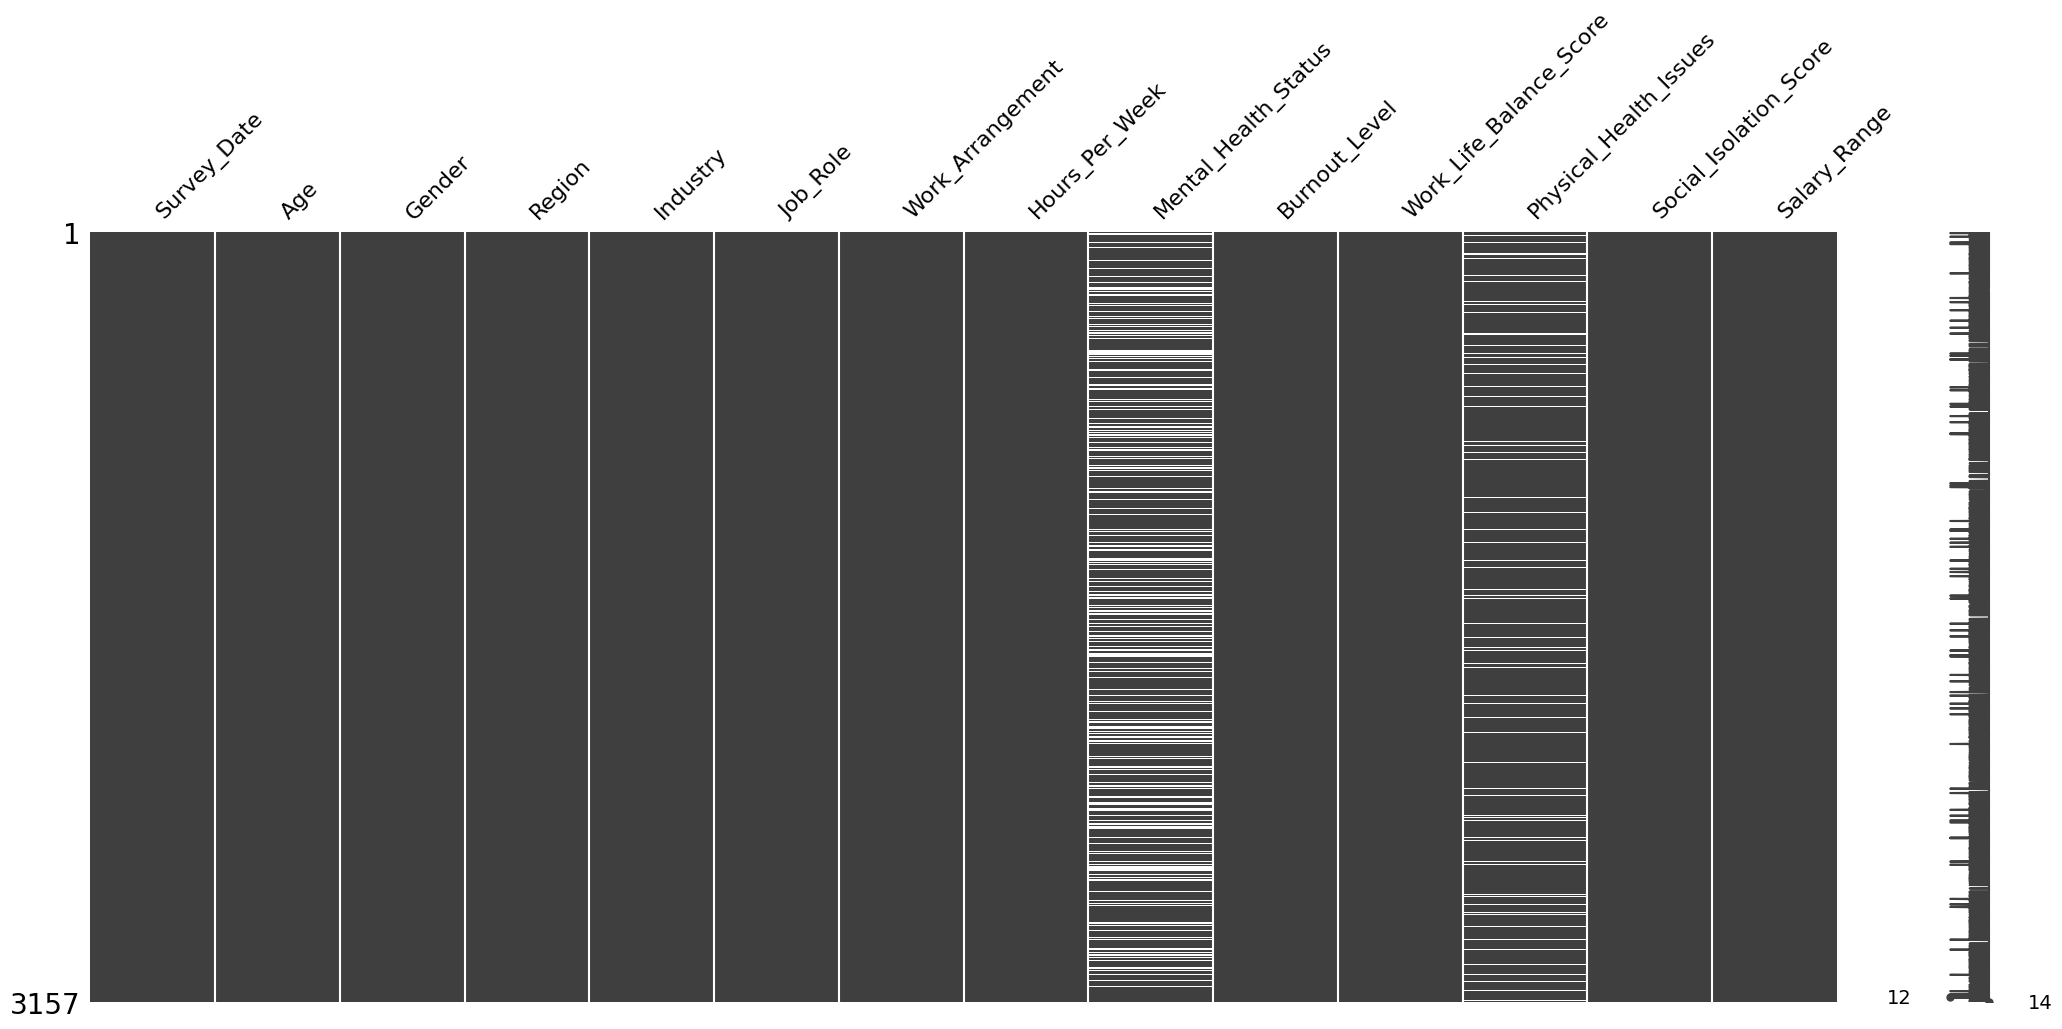

In [6]:
import missingno as msno
msno.matrix(df)

In [7]:
missing_cols=(
    df
    .isna()
    .any(axis=0)
    .loc[lambda x:x]
    .index
    )
missing_cols

Index(['Mental_Health_Status', 'Physical_Health_Issues'], dtype='object')

# Approach 1 : Drop Missing values


In [8]:
# set tracking server
mlflow.set_tracking_uri('https://dagshub.com/manikantmnnit/remote-work-health-classificatio.mlflow')

# mlflow experiment

mlflow.set_experiment("Exp 1 - Drop  vs impute VS replacement: missing values")

<Experiment: artifact_location='mlflow-artifacts:/969d4e9e2f9e48fbbf2f6f2cf51ce511', creation_time=1753386919297, experiment_id='0', last_update_time=1753386919297, lifecycle_stage='active', name='Exp 1 - Drop  vs impute VS replacement: missing values', tags={}>

In [9]:
# copy the df into another file name
df_drop_missing=df.copy()

df_drop_missing.dropna(axis=1,inplace=True)

df_drop_missing.columns

# split into X and y
X = df_drop_missing.iloc[:,:-1]
y = df_drop_missing['Salary_Range']

# drop Survey_Date col
X.drop(columns='Survey_Date',inplace=True)

# Map the target values into salary categorization
map={
    '$40K-60K':1,
    '$60K-80K' :2,
    '$80K-100K':3,
    '$100K-120K':4,
    '$120K+':5
}
y=y.map(map)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4,shuffle=True)

print("The size of train data is",X_train.shape)
print("The shape of test data is",X_test.shape)

The size of train data is (2367, 10)
The shape of test data is (790, 10)


In [10]:
# select numerical cols
num_cols=X.select_dtypes(include='number').columns.to_list()[0:2]

# select categorical cols
cat_cols=X.select_dtypes(exclude='number').columns.to_list()

ordinal_cols=['Burnout_Level']
nominal_cols=['Work_Arrangement','Gender','Region','Industry','Job_Role']

len(num_cols)+len(ordinal_cols),len(nominal_cols)

(3, 5)

In [11]:
df_drop_missing[ordinal_cols].value_counts()

Burnout_Level
Medium           1366
High             1046
Low               745
Name: count, dtype: int64

In [12]:

burnout_level=['Low','Medium','High']

# build a preprocessor

preprocessor=ColumnTransformer(
    transformers=[
        ('scalar',StandardScaler(),num_cols),
        ('nominal_encoding',OneHotEncoder(drop='first',handle_unknown='ignore',sparse_output=False),nominal_cols),
        ('ordinal_encoding',OrdinalEncoder(categories=[burnout_level]),ordinal_cols)
    ],
    remainder='passthrough',n_jobs=-1,verbose_feature_names_out=False
)
preprocessor.set_output(transform='pandas')

,transformers,"[('scalar', ...), ('nominal_encoding', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [13]:
X_train_preprocess=preprocessor.fit_transform(X_train)
X_test_preprocess=preprocessor.fit_transform(X_test)
X_train_preprocess

,Age,Hours_Per_Week,Work_Arrangement_Onsite,Work_Arrangement_Remote,Gender_Male,Gender_Non-binary,Gender_Prefer not to say,Region_Asia,Region_Europe,Region_North America,...,Job_Role_Quality Assurance,Job_Role_Research Scientist,Job_Role_Sales Representative,Job_Role_Social Media Manager,Job_Role_Software Engineer,Job_Role_Technical Writer,Job_Role_UX Designer,Burnout_Level,Work_Life_Balance_Score,Social_Isolation_Score
1046,-0.941594,1.346363,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,4
2554,-0.307074,-0.554026,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2
2177,0.882652,1.122788,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,5,3
1022,-0.941594,-0.442239,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5,3
2131,-0.148443,-0.665814,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1921,0.882652,-0.218664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,4,3
709,0.327447,1.234576,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5,3
2487,-1.179539,-1.224752,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3,1
174,1.279228,1.681726,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3


In [14]:
X_train_preprocess.shape,y_train.values.ravel().shape

((2367, 46), (2367,))

In [15]:
X_train_preprocess

,Age,Hours_Per_Week,Work_Arrangement_Onsite,Work_Arrangement_Remote,Gender_Male,Gender_Non-binary,Gender_Prefer not to say,Region_Asia,Region_Europe,Region_North America,...,Job_Role_Quality Assurance,Job_Role_Research Scientist,Job_Role_Sales Representative,Job_Role_Social Media Manager,Job_Role_Software Engineer,Job_Role_Technical Writer,Job_Role_UX Designer,Burnout_Level,Work_Life_Balance_Score,Social_Isolation_Score
1046,-0.941594,1.346363,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,4
2554,-0.307074,-0.554026,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2
2177,0.882652,1.122788,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,5,3
1022,-0.941594,-0.442239,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5,3
2131,-0.148443,-0.665814,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1921,0.882652,-0.218664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,4,3
709,0.327447,1.234576,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5,3
2487,-1.179539,-1.224752,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3,1
174,1.279228,1.681726,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3


In [16]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = 200
max_depth = 15
rf= RandomForestClassifier(random_state=42,n_estimators=n_estimators,max_depth=max_depth)

rf.fit(X_train_preprocess,y_train)

y_predict_test=rf.predict(X_test_preprocess)

from sklearn.metrics import accuracy_score

# check accuracy
print('accuracy of random Forest classifier of dropping misising values dataset',accuracy_score(y_true=y_test,y_pred=y_predict_test))



accuracy of random Forest classifier of dropping misising values dataset 0.320253164556962


##  On training data (cross-validated predictions):

In [17]:
# Cross-validation accuracy scores
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import classification_report,accuracy_score
cv_scores = cross_val_score(estimator=rf, X=X_train_preprocess, y=y_train, cv=5, scoring='accuracy')
print("Mean Accuracy from Cross-Validation:", cv_scores.mean())

# Cross-validated predictions (for classification report)
y_pred_cv = cross_val_predict(estimator=rf, X=X_train_preprocess, y=y_train, cv=5)

# Classification report on CV predictions
print("\nClassification Report (Cross-Validated Predictions):")

print(classification_report(y_true=y_train, y_pred=y_pred_cv))
classification_rep=classification_report(y_true=y_train, y_pred=y_pred_cv,output_dict=True)
for key, value in classification_rep.items():
    print(f'key {key}: value: {value}')


Mean Accuracy from Cross-Validation: 0.3409327303057065

Classification Report (Cross-Validated Predictions):
              precision    recall  f1-score   support

           1       0.32      0.03      0.05       386
           2       0.35      0.62      0.45       775
           3       0.32      0.35      0.34       710
           4       0.35      0.18      0.23       354
           5       0.33      0.01      0.03       142

    accuracy                           0.34      2367
   macro avg       0.34      0.24      0.22      2367
weighted avg       0.34      0.34      0.29      2367

key 1: value: {'precision': 0.3225806451612903, 'recall': 0.025906735751295335, 'f1-score': 0.047961630695443645, 'support': 386.0}
key 2: value: {'precision': 0.35123367198838895, 'recall': 0.6245161290322581, 'f1-score': 0.44960520204366, 'support': 775.0}
key 3: value: {'precision': 0.32087628865979384, 'recall': 0.35070422535211265, 'f1-score': 0.3351278600269179, 'support': 710.0}
key 4: value

In [18]:
report=classification_report(y_true=y_train, y_pred=y_pred_cv)
report

'              precision    recall  f1-score   support\n\n           1       0.32      0.03      0.05       386\n           2       0.35      0.62      0.45       775\n           3       0.32      0.35      0.34       710\n           4       0.35      0.18      0.23       354\n           5       0.33      0.01      0.03       142\n\n    accuracy                           0.34      2367\n   macro avg       0.34      0.24      0.22      2367\nweighted avg       0.34      0.34      0.29      2367\n'

In [19]:
accuracy_score(y_true=y_test,y_pred=y_predict_test)

0.320253164556962

In [20]:
with mlflow.start_run(run_name='Dropped Missing Values Experiment'):
    # Log parameters
    mlflow.log_param('experiment_type', 'Dropped_Missing')
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    # Log metrics on test predictions
    mlflow.log_metric('test_accuracy', accuracy_score(y_true=y_test, y_pred=y_predict_test))

    # Log cross-validation mean accuracy score
    mlflow.log_metric('cross_val_score_mean', cv_scores.mean())

    # Log classification report metrics (macro avg)
    classification_rep = classification_report(y_test, y_predict_test, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

🏃 View run Dropped Missing Values Experiment at: https://dagshub.com/manikantmnnit/remote-work-health-classificatio.mlflow/#/experiments/0/runs/6ef21727efa24f6c9ef9798992f254ea
🧪 View experiment at: https://dagshub.com/manikantmnnit/remote-work-health-classificatio.mlflow/#/experiments/0


# Approach 2 : Apply impute methods on missing values

In [21]:
df.columns

Index(['Survey_Date', 'Age', 'Gender', 'Region', 'Industry', 'Job_Role',
       'Work_Arrangement', 'Hours_Per_Week', 'Mental_Health_Status',
       'Burnout_Level', 'Work_Life_Balance_Score', 'Physical_Health_Issues',
       'Social_Isolation_Score', 'Salary_Range'],
      dtype='object')

In [22]:

# copy the df 
df_1=df.copy()

df_1

map_salary = {
    '$40K-60K': 1,
    '$60K-80K': 2,
    '$80K-100K': 3,
    '$100K-120K': 4,
    '$120K+': 5
}

# 1. Clean + map raw data (safe)
df_1['Salary_Range'] = df_1['Salary_Range'].map(map_salary)
X = df_1.iloc[:, :-1]
y = df_1['Salary_Range']
X.drop(columns='Survey_Date', inplace=True)

# 2. Split train and test first ✅
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7)

from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
impute_cols=['Physical_Health_Issues','Mental_Health_Status']

# select numerical cols
num_cols=X.select_dtypes(include='number').columns.to_list()[0:2]

# select categorical cols
cat_cols=X.select_dtypes(exclude='number').columns.to_list()

ordinal_cols=['Burnout_Level']
nominal_cols=['Work_Arrangement','Gender','Region','Industry','Job_Role']

# apply impute method
from sklearn.pipeline import Pipeline

# create a pipeline for categorical columns with imputation and Encoder
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])


# create a pipeline for nominal cols

burnout_level=['Low','Medium','High']

ord_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[burnout_level]))
])

# create apipeline for numerical cols
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


# Final column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, nominal_cols),
        ('ord', ord_pipeline, ordinal_cols)
    ],
    remainder='drop',  # Drop unused columns if any
    verbose_feature_names_out=False
)
preprocessor.set_output(transform='pandas')

# maek a pipe 
pipe=make_pipeline(preprocessor)

# apply fit and transform 

pipe.fit(X_train, y_train)            
X_train_transformed = pipe.transform(X_train)
X_test_transformed = pipe.transform(X_test)

In [23]:
# 1. Train Random Forest on transformed training data

n_estimators = 200
max_depth = 15
rf = RandomForestClassifier(random_state=42,n_estimators=n_estimators,max_depth=max_depth)

rf.fit(X_train_transformed, y_train)

# 2. Predict on test set
y_predict_test = rf.predict(X_test_transformed)

# 3. Accuracy on test data
test_accuracy = accuracy_score(y_test, y_predict_test)
print('Test Accuracy:', test_accuracy)

# 4. Cross-validation on transformed training data
cv_scores = cross_val_score(estimator=rf, X=X_train_transformed, y=y_train, cv=5, scoring='accuracy')
print("Mean Accuracy from Cross-Validation:", cv_scores.mean())

# 5. Cross-validated predictions for classification report
y_pred_cv = cross_val_predict(estimator=rf, X=X_train_transformed, y=y_train, cv=5)
print("\nClassification Report (CV predictions on training set):")
print(classification_report(y_train, y_pred_cv))

# 6. Log to MLflow
with mlflow.start_run(run_name="Imputation - RF"):
    # Log parameters
    mlflow.log_param('experiment_type', 'Imputation')
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    # Log metrics on test predictions
    mlflow.log_metric('test_accuracy', accuracy_score(y_true=y_test, y_pred=y_predict_test))

    # Log cross-validation mean accuracy score
    mlflow.log_metric('cross_val_score_mean', cv_scores.mean())

    # Log classification report metrics (macro avg)
    classification_rep = classification_report(y_test, y_predict_test, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

Test Accuracy: 0.31645569620253167
Mean Accuracy from Cross-Validation: 0.3232277526395173

Classification Report (CV predictions on training set):
              precision    recall  f1-score   support

           1       0.29      0.05      0.08       369
           2       0.34      0.54      0.42       696
           3       0.31      0.40      0.35       669
           4       0.36      0.17      0.23       326
           5       0.06      0.01      0.01       149

    accuracy                           0.32      2209
   macro avg       0.27      0.23      0.22      2209
weighted avg       0.30      0.32      0.28      2209

🏃 View run Imputation - RF at: https://dagshub.com/manikantmnnit/remote-work-health-classificatio.mlflow/#/experiments/0/runs/01b090219ca848669d9cc37fefa11c34
🧪 View experiment at: https://dagshub.com/manikantmnnit/remote-work-health-classificatio.mlflow/#/experiments/0


# Approach 3 : replacement


In [27]:

# copy the df 
df_2=df.copy()


map_salary = {
    '$40K-60K': 1,
    '$60K-80K': 2,
    '$80K-100K': 3,
    '$100K-120K': 4,
    '$120K+': 5
}

# 1. Clean + map raw data (safe)
df_2['Salary_Range'] = df_2['Salary_Range'].map(map_salary)

# fill missing values with 'fine'

values={'Mental_Health_Status':'fine','Physical_Health_Issues':'No_issue'}
df_2=df_2.fillna(values)

# split into train ans test
X = df_2.iloc[:, :-1]
y = df_2['Salary_Range']
X.drop(columns='Survey_Date', inplace=True)

# 2. Split train and test first 
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7)


# select numerical cols
num_cols=X.select_dtypes(include='number').columns.to_list()[0:2]

# select categorical cols
cat_cols=X.select_dtypes(exclude='number').columns.to_list()

ordinal_cols=['Burnout_Level']
nominal_cols=['Work_Arrangement','Gender','Region','Industry','Job_Role']

# apply impute method
from sklearn.pipeline import Pipeline

# create a pipeline for categorical columns with imputation and Encoder
cat_pipeline = Pipeline(steps=[
   ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])


# create a pipeline for nominal cols

burnout_level=['Low','Medium','High']

ord_pipeline = Pipeline(steps=[
    ('encoder', OrdinalEncoder(categories=[burnout_level]))
])

# create apipeline for numerical cols
num_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])


# Final column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, nominal_cols),
        ('ord', ord_pipeline, ordinal_cols)
    ],
    remainder='drop',  # Drop unused columns if any
    verbose_feature_names_out=False
)
preprocessor.set_output(transform='pandas')

# maek a pipe 
pipe=make_pipeline(preprocessor)

# apply fit and transform 

pipe.fit(X_train, y_train)            
X_train_transformed = pipe.transform(X_train)
X_test_transformed = pipe.transform(X_test)

In [28]:
# 1. Train Random Forest on transformed training data

n_estimators = 200
max_depth = 15
rf_2 = RandomForestClassifier(random_state=42,n_estimators=n_estimators,max_depth=max_depth)
rf_2.fit(X_train_transformed, y_train)

# 2. Predict on test set
y_predict_test = rf_2.predict(X_test_transformed)

# 3. Accuracy on test data
test_accuracy = accuracy_score(y_test, y_predict_test)
print('Test Accuracy:', test_accuracy)

# 4. Cross-validation on transformed training data
cv_scores = cross_val_score(estimator=rf_2, X=X_train_transformed, y=y_train, cv=5, scoring='accuracy')
print("Mean Accuracy from Cross-Validation:", cv_scores.mean())

# 5. Cross-validated predictions for classification report
y_pred_cv = cross_val_predict(estimator=rf_2, X=X_train_transformed, y=y_train, cv=5)
print("\nClassification Report (CV predictions on training set):")
print(classification_report(y_train, y_pred_cv))

# 6. Log to MLflow
with mlflow.start_run(run_name="Replacement- RF"):
    mlflow.log_param("experiment_type", "replacement")
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    # Log metrics on test predictions
    mlflow.log_metric('test_accuracy', accuracy_score(y_true=y_test, y_pred=y_predict_test))

    # Log cross-validation mean accuracy score
    mlflow.log_metric('cross_val_score_mean', cv_scores.mean())

    # Log classification report metrics (macro avg)
    classification_rep = classification_report(y_test, y_predict_test, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

Test Accuracy: 0.3291139240506329
Mean Accuracy from Cross-Validation: 0.34449369491386295

Classification Report (CV predictions on training set):
              precision    recall  f1-score   support

           1       0.27      0.03      0.06       364
           2       0.36      0.64      0.46       728
           3       0.32      0.36      0.34       663
           4       0.30      0.10      0.16       305
           5       0.32      0.06      0.10       149

    accuracy                           0.34      2209
   macro avg       0.32      0.24      0.22      2209
weighted avg       0.33      0.34      0.29      2209

🏃 View run Replacement- RF at: https://dagshub.com/manikantmnnit/remote-work-health-classificatio.mlflow/#/experiments/0/runs/0f536ebec5924c668e748652223cdb6b
🧪 View experiment at: https://dagshub.com/manikantmnnit/remote-work-health-classificatio.mlflow/#/experiments/0
